# scVI for cell type prediction and data projection

This notebook provides examples to utilize the pretrained SCVI model with user data. For more information on the model please refer to the [Census model page](https://cellxgene.cziscience.com/census-models).

**IMPORTANT:** This tutorial requires cellxgene-census package version 1.9.1 or later.

**Contents**

1. Requirements.
1. Preparing data and model.
1. Using the SCVI pretrained model for **data projection**.
1. Using the SCVI pretrained model for **cell type inference**.


⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Requirements

### System requirements

To run this notebook the following are required:

- Unix system.
- A system with one or more GPUs is highly recommended.
- [AWS command-line interface](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html).
- [scvi-tools](https://github.com/scverse/scvi-tools) and its dependencies.
- CELLxGENE Census package

### Downloading example data

Throughout the notebook the 10X PBMC 3K dataset will be used, you can download it via the following shell commands.


In [1]:
!mkdir -p data
!wget -nv -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

2023-12-14 22:13:59 URL:https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [7621991/7621991] -> "data/pbmc3k_filtered_gene_bc_matrices.tar.gz" [1]


### Downloading the trained scVI model

The model is currently hosted in S3, you can find out more deatails in the [Census model page](https://cellxgene.cziscience.com/census-models).

Additional information, including its S3 URI, is also included in the metadata of the corresponding embeddings inside Census. These metadata can be obtained as follows.

In [2]:
import cellxgene_census
import json

census = cellxgene_census.open_soma(census_version="2023-12-15")

scvi_info = census["census_data"]["homo_sapiens"].ms["RNA"].obsm["scvi"].metadata
scvi_info = json.loads(scvi_info["CxG_embedding_info"])

In [3]:
scvi_info["model_link"]

's3://cellxgene-contrib-public/models/scvi/2023-12-15/homo_sapiens/model.pt'

In [4]:
!aws s3 sync s3://cellxgene-contrib-public/models/scvi/2023-12-15/homo_sapiens/ 2023-12-15-scvi-homo-sapiens/scvi.model/

## Using the SCVI pretrained model for **data projection**
Import all the required packages for this demonstration

In [5]:
import warnings

warnings.filterwarnings("ignore")

import functools
import gc
import scanpy as sc
import os
import cellxgene_census
import anndata
import numpy as np
import pandas as pd
import scvi
import tiledbsoma as soma
import yaml
from sklearn.ensemble import RandomForestClassifier

Load the example query dataset (the 10X pbmc3k data).

In [6]:
adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))
# initialize the batch to be unassigned. This could be any dummy value.
adata.obs["batch"] = "unassigned"

Load the SCVI model and prepare the query data

In [7]:
folder = "2023-12-15-scvi-homo-sapiens"

model_filename = f"{folder}/scvi.model"
scvi.model.SCVI.prepare_query_anndata(adata, model_filename)

INFO     File 2023-12-15-scvi-homo-sapiens/scvi.model/model.pt already downloaded                                  
INFO     Found 62.2% reference vars in query data.                                                                 


Load the query data into the model, set "is_trained" to True to trick the model into thinking it was already trained, and do a forward pass through the model to get the latent reprsentation of the query data.

In [8]:
vae_q = scvi.model.SCVI.load_query_data(
    adata,
    model_filename,
)

# This allows for a simply forward pass
vae_q.is_trained = True
latent = vae_q.get_latent_representation()
adata.obsm["scvi"] = latent

# filter out missing features
adata = adata[:, adata.var["gene_symbols"].notnull().values].copy()
adata.var.set_index("gene_symbols", inplace=True)

INFO     File 2023-12-15-scvi-homo-sapiens/scvi.model/model.pt already downloaded                                  


CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12020, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Run UMAP

In [9]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata)

Run leiden clustering

In [10]:
sc.tl.leiden(adata)

Normalize and log-transform the expression data

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Using the marker genes from the [Scanpy pbmc3k vignette](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html), we can map our leiden clusters to the corresponding cell type labels used in the tutorial. Our Leiden clustering does not match up perfectly so we need to visualize the marker genes to appropriately map the clusters to the original cell type annotation.
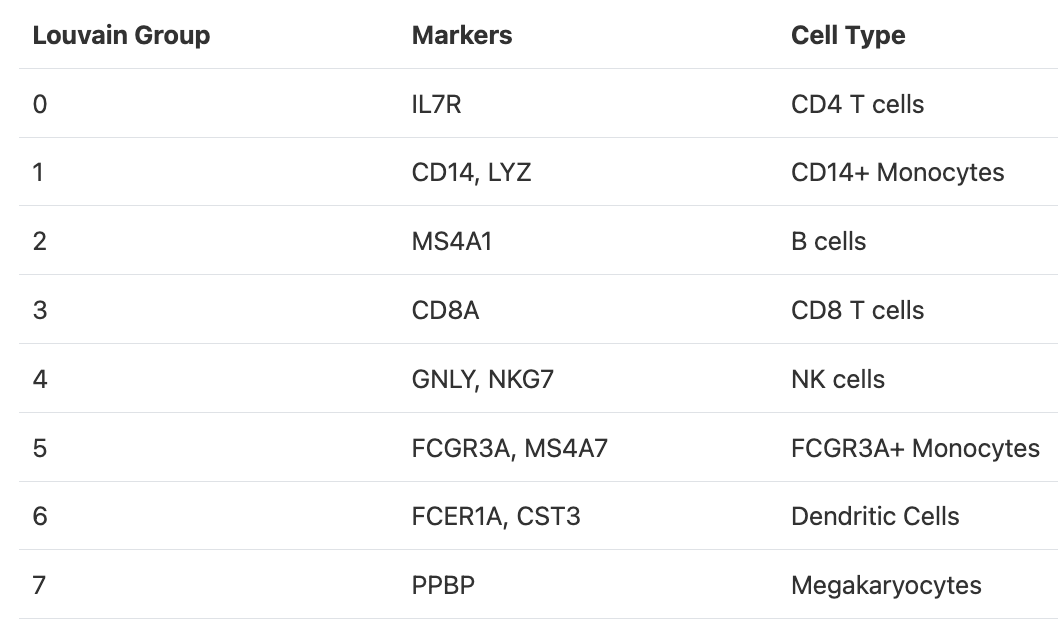

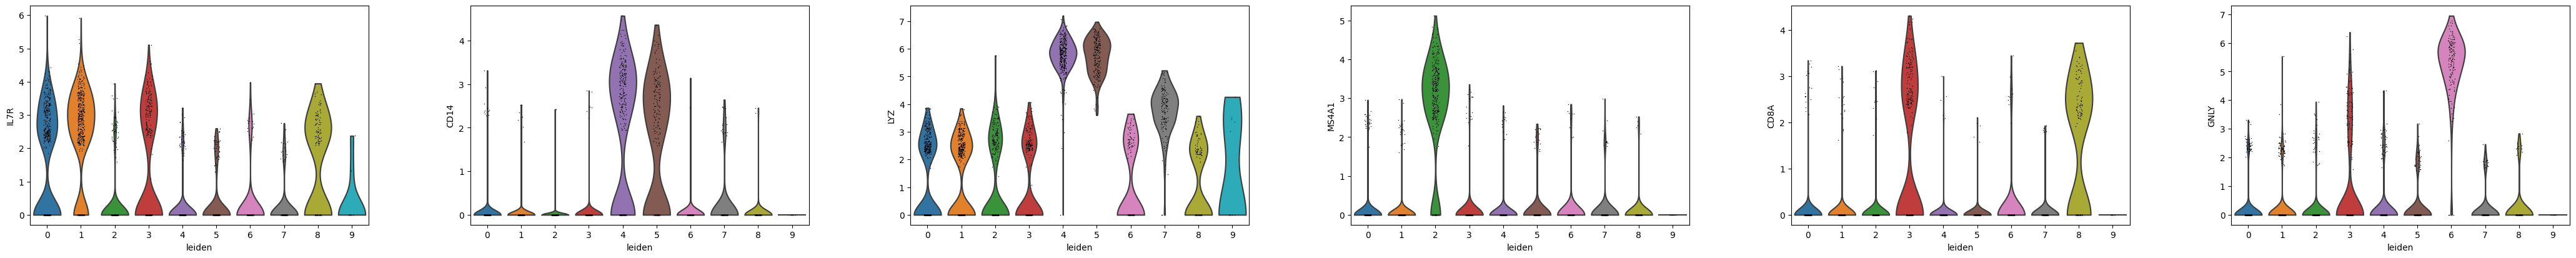

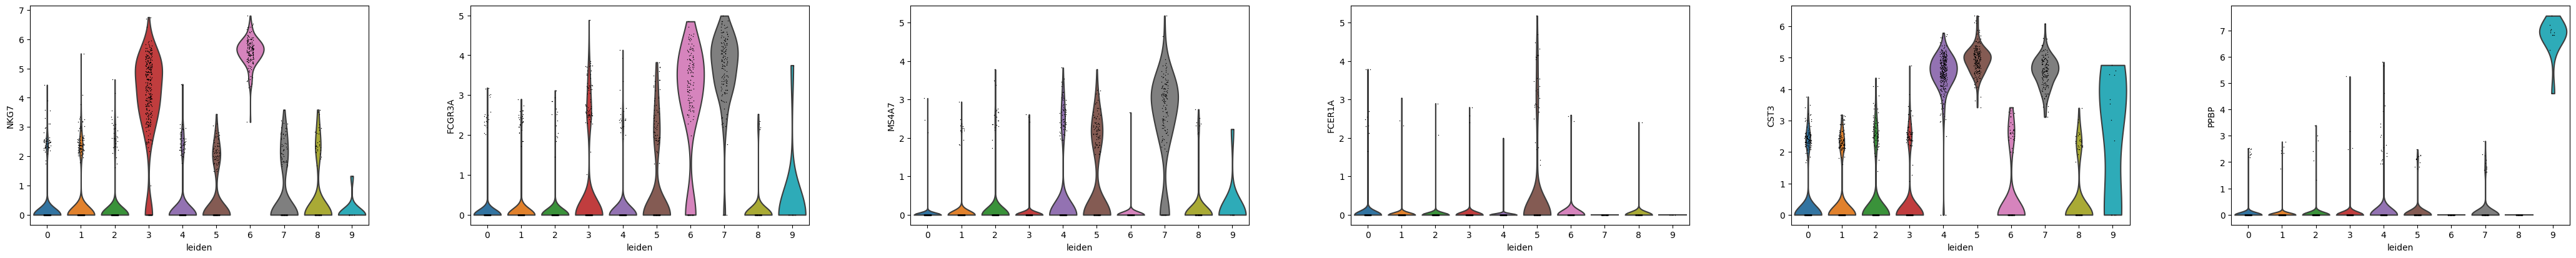

In [12]:
markers_row1 = ["IL7R", "CD14", "LYZ", "MS4A1", "CD8A", "GNLY"]
markers_row2 = ["NKG7", "FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    sc.pl.violin(adata, markers_row1, groupby="leiden")
    sc.pl.violin(adata, markers_row2, groupby="leiden")

Based on the expression of the provided marker genes, we can make the following Leiden clusters to these cell type labels:

 - 0,1 = CD4 T cells
 - 4,5 = CD14+ monocytes
 - 3 = B cells
 - 2 = CD8 T cells
 - 6 = NK cells
 - 7 = FCGR3A+ Monocytes
 - 5 = dendritic cells
 - 8 = megakaryocytes

In [13]:
original_cell_types = [
    "CD4 T cells",
    "CD4 T cells",
    "B cells",
    "CD8 T cells",
    "CD14+ monocytes",
    "dendritic cells",
    "NK cells",
    "FCGR3A+ Monocytes",
    "megakaryocytes",
]
label_mapping = dict(zip(range(len(original_cell_types)), original_cell_types))
adata.obs["original_cell_type"] = adata.obs["leiden"].apply(lambda x: label_mapping[int(x)])

KeyError: 9

In [ ]:
sc.pl.umap(adata, color=["original_cell_type"])

Display the scatter plot

## Using the SCVI pretrained model for **cell cell type inference**.

Fetch the reference SCVI embeddings corresponding to some example PBMC data from Census

In [14]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

# Some PBMC data from these collections
# 1. https://cellxgene.cziscience.com/collections/c697eaaf-a3be-4251-b036-5f9052179e70
# 2. https://cellxgene.cziscience.com/collections/f2a488bf-782f-4c20-a8e5-cb34d48c1f7e
dataset_ids = ["fa8605cf-f27e-44af-ac2a-476bee4410d3", "3c75a463-6a87-4132-83a8-c3002624394d"]

adata_census = cellxgene_census.get_anndata(
    census=census,
    measurement_name="RNA",
    organism="Homo sapiens",
    obs_value_filter=f"dataset_id in {dataset_ids}",
    obsm_layers=["scvi"],
)
adata_census.var.set_index("feature_id", inplace=True)

Let's run UMAP on a subset of the reference combined with the query dataset and plot the UMAP, coloring by dataset ID.

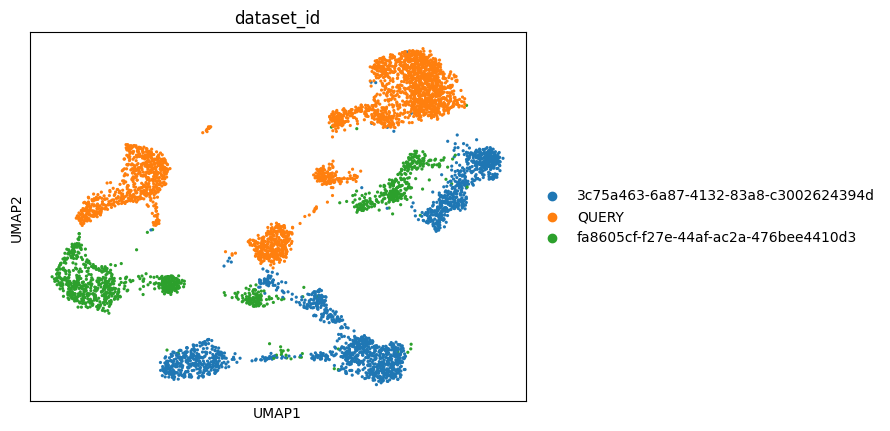

In [15]:
adata.obs["dataset_id"] = "QUERY"
# Subset the reference dataset to have a similar number of cells to the query dataset
index_subset = np.random.choice(adata_census.n_obs, size=3000, replace=False)
adata_census_subset = adata_census[index_subset, :]

adata_combined = anndata.concat([adata_census_subset, adata])
sc.pp.neighbors(adata_combined, n_neighbors=15, use_rep="scvi", metric="correlation")
sc.tl.umap(adata_combined)
sc.pl.umap(adata_combined, color=["dataset_id"])

Fit a Random Forest Classifier on the reference SCVI embedding fetched from Census and use it to predict cell type labels on the projected SCVI embedding for the query dataset.

In [16]:
rfc = RandomForestClassifier()
rfc.fit(adata_census.obsm["scvi"], adata_census.obs["cell_type"].values)
adata.obs["predicted_cell_type"] = rfc.predict(adata.obsm["scvi"])

Plot the results and compare the annotations

In [ ]:
sc.pl.umap(adata, color=["original_cell_type", "predicted_cell_type"])

Let's look at the predicted cell type annotations on the combin

In [ ]:
adata_combined.obs["cell_type"] = (
    adata_census_subset.obs["cell_type"].tolist() + adata.obs["predicted_cell_type"].tolist()
)
sc.pl.umap(adata_combined, color=["dataset_id", "cell_type"])